In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import os
os.chdir("../")

import pandas as pd
import numpy as np
import xarray as xr

from tqdm import tqdm_notebook as tqdm

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy import stats
from deepflow.plotting_utils import colorbar, load_folders, create_simulation_time_axis
from deepflow.plotting_utils import get_unconditionals, determine_connected
from deepflow.plotting_utils import plot_misfit_histograms

In [3]:
plot = True
working_dir = './results/runs/'
perm = "low_perm"


#Creates the simulation time axis
dts = create_simulation_time_axis()

#Load the ground truth case from the test set, corresponds to test set model 67
gt = np.load("./results/model_67_x.npy")
envelope = gt[0, :, ::-1].T

In [4]:
ds_ref = xr.open_dataset(working_dir+perm+'/reference/reference.nc')
qor_ref = ds_ref['state_variables'][dict(state_variable=2, well=1)]*(-60*60*24)
qwr_ref = ds_ref['state_variables'][dict(state_variable=1, well=1)]*(-60*60*24)
p_ref = ds_ref['state_variables'][dict(state_variable=0, well=0)]/1e5

ref_curves = [qor_ref, qwr_ref, p_ref]

In [5]:
def extract_curves(folder, N=500):
    qor_curves = []
    qwr_curves = []
    p_curves = []
    perms = []
    
    for i in tqdm(range(0, N)):
        try:
            ds = xr.open_dataset(folder+'/iteration_'+str(i)+'.nc')
            qor_curves.append(ds['state_variables'][dict(state_variable=2, well=1)]*(-60*60*24))
            qwr_curves.append(ds['state_variables'][dict(state_variable=1, well=1)]*(-60*60*24))
            p_curves.append(ds['state_variables'][dict(state_variable=0, well=0)]/1e5)
            perms.append(ds['material_properties'][1].values)
            
            ds.close()
        except FileNotFoundError or KeyError:
            pass
    return np.array(qor_curves), np.array(qwr_curves), np.array(p_curves), np.array(perms)

qor_curves, qwr_curves, p_curves, perms = extract_curves("./results/runs/paper/low_perm_flowwells_adam_gauss/run_66")

In [6]:
def inverse_permeability_transform(x, a=0.001, b=1e-12):
    return x/b-a

In [7]:
facies = np.array([np.where(inverse_permeability_transform(p)>0.5, 1, 0)[::-1] for p in perms])
print(facies.shape)

(500, 64, 128)


In [8]:
# inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 8, # fontsize for x and y labels (was 10)
    'axes.titlesize': 8,
    'font.size': 8, # was 10
    'legend.fontsize': 10, # was 10
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex': True,
    'figure.figsize': [14, 12],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

In [9]:
print(qor_curves.shape)

(500, 37)


In [10]:
curves = np.swapaxes(np.array([qor_curves, qwr_curves, p_curves]), 0, 1)
print(curves.shape)

(500, 3, 37)


In [11]:
misfits_flowwells = np.load("./results/misfits/low_perm/misfits_flowwells_adam_gauss.npy")
print(np.argmin(misfits_flowwells[66][:, 3]))

246


In [12]:
misfits_case = misfits_flowwells[66][:, 3:]

errors = [[0, *misfits_case[0]]]
for i, (error) in enumerate(misfits_case):
    if error[0] < errors[-1][1]:
        errors.append([i, error[0], error[1]])
        
errors = np.array(errors)
print(errors)
curves_case = curves[errors[:, 0].astype(int)]

print(len(curves_case))

[[0.00000000e+00 7.84260010e+02 4.06250000e-01]
 [1.00000000e+00 5.31799622e+02 5.23437500e-01]
 [2.00000000e+00 4.51725922e+02 5.78125000e-01]
 [3.00000000e+00 3.66837311e+02 6.01562500e-01]
 [4.00000000e+00 2.75908051e+02 5.93750000e-01]
 [5.00000000e+00 9.38912964e+01 5.85937500e-01]
 [6.00000000e+00 2.57478199e+01 5.70312500e-01]
 [7.00000000e+00 7.77341604e+00 6.32812500e-01]
 [8.00000000e+00 1.05574083e+00 6.71875000e-01]
 [9.00000000e+00 1.04161218e-01 6.95312500e-01]
 [1.00000000e+01 1.15988813e-02 6.71875000e-01]
 [1.10000000e+01 1.12498272e-02 6.71875000e-01]
 [6.60000000e+01 2.28614756e-03 9.53125000e-01]
 [1.10000000e+02 7.27013685e-04 9.84375000e-01]
 [1.89000000e+02 5.57973515e-04 9.92187500e-01]
 [1.90000000e+02 2.68517935e-04 9.76562500e-01]
 [2.46000000e+02 1.93474756e-04 9.92187500e-01]]
17


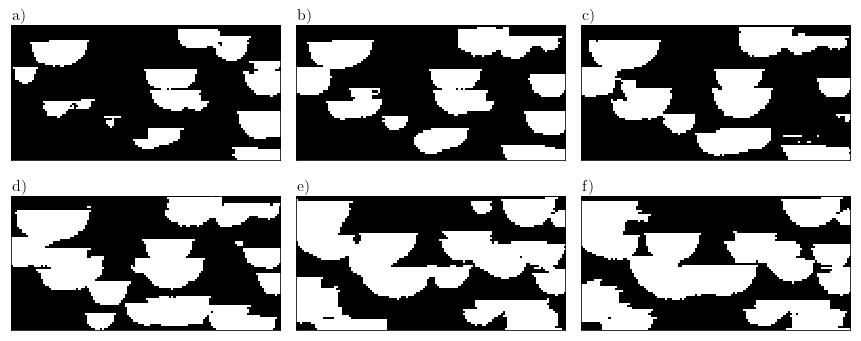

In [13]:
facies_case = facies[errors[:, 0].astype(int)]
facies_case_selected = facies_case[[0, 2, 5, 8, 14, -1]]

fig, ax = plt.subplots(2, 3, figsize=(12, 6))
for a, im in zip(ax.flatten(), facies_case_selected):
    a.imshow(im, cmap="gray")
    a.set_xticks([])
    a.set_yticks([])

for a, label, left, up in zip(ax.flatten(), ["a)", "b)", "c)", "d)", "e)", "f)"], [0]*6, [66]*6):
    a.text(left, up, label, fontsize=16)    
    
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=-0.3)
if plot:
    plt.savefig("./results/figures/evolution_facies.png", dpi=300, bbox_inches="tight")

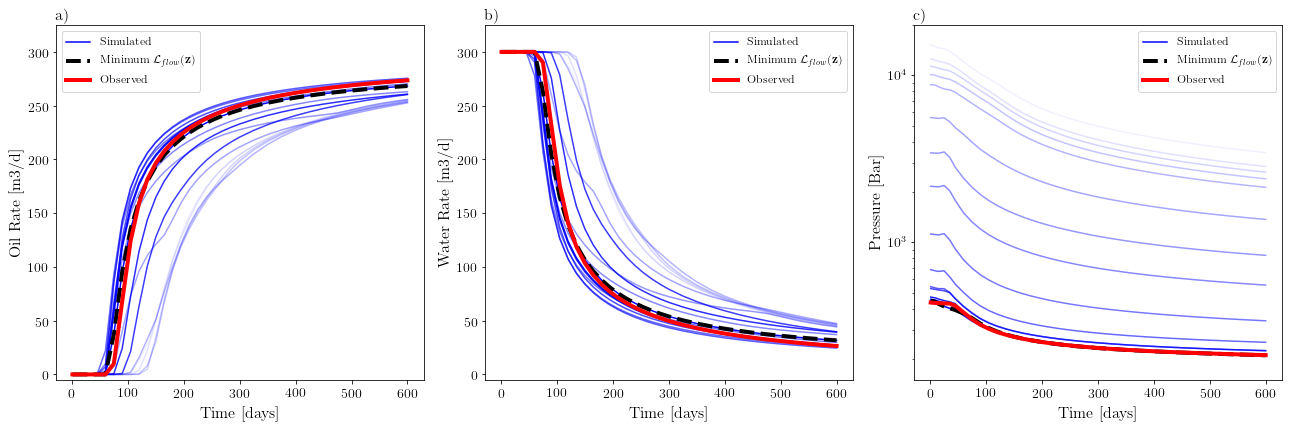

In [14]:
def plot_rate_curves(axarr, min_curves, ref_curves, dts, min_error, method="-Adam", color="blue", alpha=0.1, ref_color="red"):
    for j, curves in enumerate(min_curves):
        if j == len(min_curves)-1:
            for k in range(3):
                axarr[k].plot(dts, curves[k], color='b', alpha=(j+1)/(len(min_curves)), label="Simulated")
        else:
            for k in range(3):
                axarr[k].plot(dts, curves[k], color='b', alpha=(j+1)/(len(min_curves)))   
    
    min_error_c = min_curves[-1]
    for k in range(3):
        axarr[k].plot(dts, min_error_c[k], color='black', alpha=1.0, linewidth=4, linestyle="--", label=r"Minimum $\mathcal{L}_{flow}(\mathbf{z})$")  
                
    for i, t, loc  in zip(range(3), ["Oil Rate [m3/d]", "Water Rate [m3/d]", "Pressure [Bar]"], [0, 1, 1]):
        axarr[i].plot(dts, ref_curves[i], color=ref_color, linewidth=4, linestyle="-", label="Observed")
        axarr[i].set_ylabel(t, fontsize=16)
        axarr[i].legend(fontsize=12, loc=loc)

    for a in axarr:
        a.set_xlabel("Time [days]", fontsize=16)
    
    axarr[0].set_ylim(-5, 325)
    axarr[1].set_ylim(-5, 325)
    axarr[2].set_yscale("log")
    axarr[2].set_ylim(150, 20000)
    
fig, axarr = plt.subplots(1, 3, figsize=(6*3, 6))
plot_rate_curves(axarr, curves_case, [qor_ref, qwr_ref, p_ref], dts, 246)

for a, label, left, up in zip(axarr.flatten(), ["a)", "b)", "c)"], [-30]*3, [330, 330, 2.15e4]*3):
    a.text(left, up, label, fontsize=16)    
    

fig.tight_layout()
if plot:
    plt.savefig("./results/figures/evolution_flowwells_case_66.png", dpi=300, bbox_inches="tight")

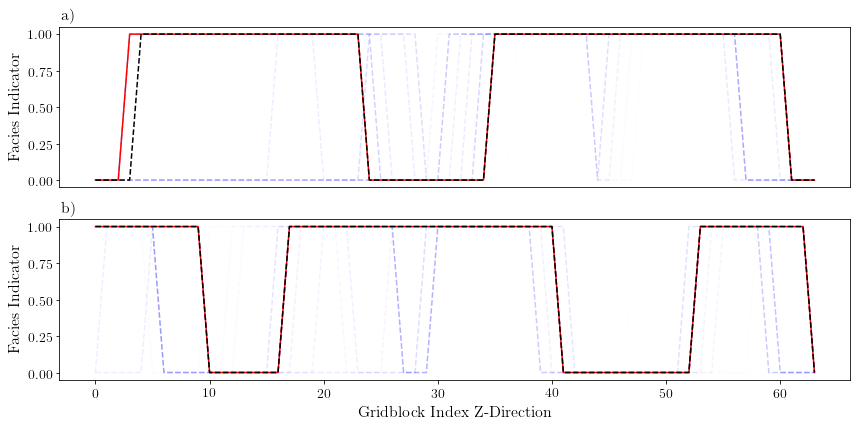

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
for j, w in enumerate([8, 120]):
    for i, f in enumerate(facies_case[:-1]):
        ax[j].plot(f[:, w], c="blue", linestyle="--", alpha=(i+1)/(len(facies_case)*10))
    ax[j].plot(envelope[:, w], c="red", linestyle="-")
    ax[j].plot(facies_case[-1, :, w], c="black", linestyle="--", alpha=1.0)
    ax[j].set_ylabel("Facies Indicator", fontsize=16)
ax[0].set_xticks([])

for a, label, left, up in zip(ax.flatten(), ["a)", "b)"], [-3]*2, [1.1]*2):
    a.text(left, up, label, fontsize=16)    
    
ax[1].set_xlabel("Gridblock Index Z-Direction", fontsize=16)
fig.tight_layout()
if plot:
    plt.savefig("./results/figures/well_acc_evolution_flowwells_case_66.png", dpi=300, bbox_inches="tight")

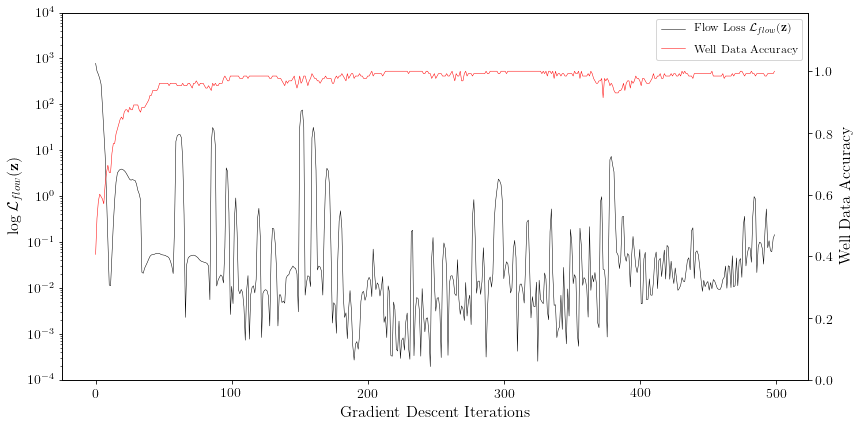

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6*2, 6))
h1 = ax.plot(misfits_case[:, 0], color="black", linewidth=0.5, label=r"Flow Loss $\mathcal{L}_{flow}(\mathbf{z})$")
ax2 = ax.twinx()
h2 = ax2.plot(misfits_case[:, 1], color="red", linewidth=0.5, label=r"Well Data Accuracy")
ax.set_yscale("log")

# added these three lines
m=0
lns = list(h1)+list(h2)

labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, fontsize=12, loc=0)

ax.set_ylim(1e-4, 1e4)
ax2.set_ylim(0, 1.19)
ax.set_xlabel("Gradient Descent Iterations", fontsize=16)
ax.set_ylabel(r"$\log{\mathcal{L}_{flow}(\mathbf{z})}$", fontsize=16)
ax2.set_ylabel("Well Data Accuracy", fontsize=16)
fig.tight_layout()

if plot:
    plt.savefig("./results/figures/functional_flowwells_case_66.png", dpi=300, bbox_inches="tight")